<a href="https://colab.research.google.com/github/gadgil-group/School_Pb_water/blob/main/NY_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import packages used in all code
import pandas as pd
from google.colab import drive
from sklearn.neighbors import DistanceMetric
from sklearn.feature_selection import RFE
from scipy import stats
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
#import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.utils import resample
from random import seed
from random import randint
from sklearn.metrics import roc_curve, auc, precision_recall_curve,  average_precision_score
from numpy import argmax
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import ShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
import os
import seaborn as sns
from random import sample
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from IPython.display import Image
from pydotplus import graph_from_dot_data
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.neural_network import MLPClassifier
drive.mount('/content/drive')
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from datetime import datetime as dt
import requests
import io
import requests


##############################################################################################
#Preprocess data
#Drop non-numerical columns
#Simple Imputer 
#Params: df: complete dataframe with all data, Pb_threshold: threshold to binarize label,
#        normalize: normalization option
##############################################################################################
def preprocess_data(df, Pb_threshold, normalize):
    features = df.copy()
    features.drop('Number of Outlets, Result > 15 ppb', inplace = True, axis = 1)
    features.drop('Number of Outlets, Result ≤ 15 ppb', inplace = True, axis = 1)
    features.drop(features.iloc[:, 0:3], inplace = True, axis = 1) 
    features.drop(columns={'Sampling Complete','All Results Received\t', 'Date All Results Received','School Website\t', 'BEDS Code', 'School Street ',	'School City',	'School State',	'School Zip Code',	'Date Sampling Updated',	'Date Results Updated',	'County Location',	'Location', 'Sampling Completion Date', 'Out of Service',  
       'Out of Service', 'Previously Sampled Outlets', 'unsafe', 'lat', 'lon', 'PWSID'}, inplace=True, axis=1)
   
    features.drop(columns={'Type of Organization',  'Any Buildings with Lead-Free Plumbing?'}, inplace=True)
    features = features.dropna(how='all', axis=1)
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    features = pd.DataFrame(imputer.fit_transform(features), columns = features.columns)
    labels = df['Number of Outlets, Result > 15 ppb']>0
    #imputer = IterativeImputer()
    #features = pd.DataFrame(imputer.fit_transform(features), columns = features.columns)
    
    #normalize data
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(features)
        features = pd.DataFrame(x_scaled, columns = features.columns)
    print(features.shape, labels.shape)
    return features, labels


Mounted at /content/drive


In [ ]:
#SDWIS Violations data from region 2 (NY)
#Documentation - https://www.epa.gov/enviro/web-services

url_violations = "https://data.epa.gov/efservice/VIOLATION/EPA_REGION/02/CSV"
violations_json = requests.get(url_violations).content
violations_csv = pd.read_csv(io.StringIO(violations_json.decode('utf-8')), engine='python',encoding='utf-8', error_bad_lines=False)
#Cleaning data
#Dropping inactive facilities
violations_csv.drop(violations_csv[violations_csv['PWS_ACTIVITY_CODE'] == 'I'].index, inplace=True)
violations_columns = ['PWSID', 'CONTAMINANT_CODE']
violations_csv_relevant =  pd.DataFrame(violations_csv, columns = violations_columns)


violations_csv_relevant = violations_csv_relevant.pivot_table(index='PWSID', columns='CONTAMINANT_CODE', aggfunc={'CONTAMINANT_CODE':'size'}, fill_value=0)
#Dropping all 0 columns
zero_cols = violations_csv_relevant.columns[(violations_csv_relevant == 0).all()]
violations_csv_relevant.drop(labels=zero_cols, axis=1, inplace=True)
violations_csv_relevant.columns = violations_csv_relevant.columns.droplevel(0)
violations_csv_relevant = pd.merge(violations_csv_relevant, violations_csv[['PWSID','POPULATION_SERVED_COUNT']], left_index=True, right_on='PWSID').set_index('PWSID')
#Assigning contaminant names to codes
codes = pd.read_csv('/content/drive/My Drive/data/SDWA_REF_CODE_VALUES.csv')
codes.drop(columns='VALUE_TYPE', inplace=True)
column_names = dict(zip(codes.VALUE_CODE, codes.VALUE_DESCRIPTION))
column_names['POPULATION_SERVED_COUNT']='POPULATION_SERVED_COUNT'

violations_csv_relevant.columns = [column_names[i] for i in violations_csv_relevant.columns]

violations_csv_relevant.columns

<ipython-input-2-4249da8895be>:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  violations_csv = pd.read_csv(io.StringIO(violations_json.decode('utf-8')), engine='python',encoding='utf-8', error_bad_lines=False)


Index(['Turbidity', 'Surface Water Treatment Rule',
       'Interim Enhanced Surface Water Treatment Rule',
       'Stage 1 Disinfectants and Disinfection Byproducts Rule',
       'Stage 2 Disinfectants and Disinfection Byproducts Rule',
       'Groundwater Rule', 'Long Term 2 Enhanced Surface Water Treatment Rule',
       'Chlorine', 'Arsenic', 'Chlorine dioxide',
       ...
       'Gross Alpha, Incl. Radon and U', 'Combined Uranium',
       'Combined Radium (-226 and -228)', 'Radium-226', 'Radium-228',
       'Lead and Copper Rule', 'Consumer Confidence Rule', 'Public Notice',
       'Revised Total Coliform Rule', 'POPULATION_SERVED_COUNT'],
      dtype='object', length=169)

In [ ]:
#SDWIS PWS ZIP code data from region 2 (NY)
url_zipcode =  "https://data.epa.gov/efservice/WATER_SYSTEM/STATE_CODE/NY/CSV"
zipcode_json = requests.get(url_zipcode).content
zipcode_csv = pd.read_csv(io.StringIO(zipcode_json.decode('utf-8')), engine='python',encoding='utf-8', error_bad_lines=False)
zipcode_csv = pd.DataFrame(zipcode_csv, columns = ['PWSID', 'ZIP_CODE'])
#Largest water utility from each zip
ny_water_utilities = pd.merge(zipcode_csv, violations_csv_relevant, how='inner', left_on='PWSID', right_on='PWSID')
ny_water_utilities.sort_values(by=['POPULATION_SERVED_COUNT'], inplace=True)
ny_water_utilities.drop_duplicates(subset=['ZIP_CODE'], keep='first')
ny_water_utilities.drop(columns={'Lead and Copper Rule'}, inplace=True)
ny_water_utilities['ZIP_CODE']  =ny_water_utilities['ZIP_CODE'] .str[:5]
ny_water_utilities['ZIP_CODE'] = ny_water_utilities['ZIP_CODE'].astype('int')

<ipython-input-9-89ac9ae21662>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  zipcode_csv = pd.read_csv(io.StringIO(zipcode_json.decode('utf-8')), engine='python',encoding='utf-8', error_bad_lines=False)


,PWSID,ZIP_CODE,Turbidity,Surface Water Treatment Rule,Interim Enhanced Surface Water Treatment Rule,Stage 1 Disinfectants and Disinfection Byproducts Rule,Stage 2 Disinfectants and Disinfection Byproducts Rule,Groundwater Rule,Long Term 2 Enhanced Surface Water Treatment Rule,Chlorine,...,"Gross Alpha, Excl. Radon and U","Gross Alpha, Incl. Radon and U",Combined Uranium,Combined Radium (-226 and -228),Radium-226,Radium-228,Consumer Confidence Rule,Public Notice,Revised Total Coliform Rule,POPULATION_SERVED_COUNT
476,NY3700932,13044,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
574,NY3718415,13167,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1154,NY4911816,14541,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
586,NY4905195,14886,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1286,NY3221798,13471,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,NY0100191,12054,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31000
755,NY2912267,11050,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,34000
1065,NY5103276,11743,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,34522
1698,NY5903469,10598,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,36000


In [3]:

def create_distance_matrix(data):
  dist = DistanceMetric.get_metric('euclidean')
  data['lat'] = np.radians(data['lat'].values.astype(float))
  data['lon'] = np.radians(data['lon'].values.astype(float))
  distances = pd.DataFrame(dist.pairwise(data[['lat','lon']].to_numpy())*6373,  columns=data['School'], index=data['School'])
  return distances
  
#Modified find closest algorithm 
def find_closest_school(full_set, x, train_set, distances): 
    x['Closest school with lead'] = np.nan
    schools_in_x = x['School'].tolist()
    schools_with_pb = full_set.loc[full_set['unsafe']==1, 'School'].tolist()
    schools_train_set_with_pb = train_set.loc[train_set['School'].isin(schools_with_pb), 'School'].tolist()
    all_schools = full_set['School'].tolist()
    distances.index = distances.columns.tolist()
    for school in schools_in_x:
        compare_schools = distances[[school]]
        compare_schools.sort_values(by = school, inplace=True)
        compare_schools['School'] = compare_schools.index.astype(str)
        compare_schools = compare_schools[compare_schools['School'].isin(schools_train_set_with_pb)]
        distance_to_school =  compare_schools.iloc[0, :][school]
        i = 1
        while distance_to_school==0:
          distance_to_school =  compare_schools.iloc[i, :][school]
          i = i+1
        x.loc[x['School']==school, 'Closest school with lead'] =distance_to_school

    return x['Closest school with lead']


In [ ]:
#Combine dataset for utilities and socioeconomic paramters and save
Pb_data = pd.read_csv('/content/drive/My Drive/data/NY dataset full.csv')
Pb_data['unsafe'] = Pb_data['Number of Outlets, Result > 15 ppb']>0
Pb_data = Pb_data.merge(ny_water_utilities, left_on='zip code', right_on= 'ZIP_CODE')
Pb_data = Pb_data.drop_duplicates('School')
Pb_data.to_csv("/content/drive/My Drive/data/NY full dataset with utilities.csv", index=False)


<ipython-input-16-c6b381115816>:2: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  Pb_data = pd.read_csv('/content/drive/My Drive/data/NY dataset full.csv')


In [4]:
##############################################################################################
#Random forest model - predicts whether Pb leaching is likely to occur in a school based on 
#water quality and socio-economic data
##############################################################################################
Pb_data = pd.read_csv('/content/drive/My Drive/data/NY full dataset with utilities.csv')
distance_matrix = create_distance_matrix(Pb_data)
features_over_size={}
features, labels = preprocess_data(Pb_data, 15, True)

#Defining the range of split sizes
sizes = np.concatenate([np.arange(0.9, 1, -0.05), np.arange(0.9, 0.1, -0.1)])
auc_scores_size=[]
f1_scores_all=[]
precision_scores_all=[]
precision_scores_errors=[]
recall_scores_all=[]
recall_scores_errors=[]
y_errors_roc=[]
y_errors_f1=[]
feature_importances=[]

#split features and lables into train and test set

for size in sizes:
  train_features, test_features, train_labels, test_labels= train_test_split(features, 
      labels, test_size = size, random_state = 42)
  train_features.fillna(train_features.mean(), inplace=True)
  test_features.fillna(test_features.mean(), inplace=True)

  train_features_with_name = train_features.merge(Pb_data[['School']], how='left',  left_index=True, right_index=True).dropna()
  test_features_with_name = test_features.merge(Pb_data[['School']], how='left', left_index=True, right_index=True).dropna()

  test_features['Closest School Pb'] = find_closest_school(Pb_data, test_features_with_name, train_features_with_name, distance_matrix)
  train_features['Closest School Pb'] = find_closest_school(Pb_data, train_features_with_name, train_features_with_name, distance_matrix)
  rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, criterion='entropy', max_depth= 20, oob_score=True, class_weight={0:1,1:100})
  rf.fit(train_features.fillna(0), train_labels)

#Define decision threshold for random forest
  threshold = 0.5

  # Predict using selected threshold
  predicted_proba = rf.predict_proba(test_features.fillna(0))
  rf_prediction = (predicted_proba [:,1] >= threshold).astype('int')
  fpr, tpr, thresholds = roc_curve(test_labels, predicted_proba[:,1])
  # get area under the curve
  roc_auc = auc(fpr, tpr)
  importances = rf.feature_importances_

  precision, recall, thresholds = precision_recall_curve(test_labels, predicted_proba[:,1])
  # average precision score
  avg_precision = average_precision_score(test_labels, predicted_proba[:,1])
  # precision auc
  pr_auc = auc(recall, precision)
  #chose best threshold based on f score
  zeros = np.where(precision == 0)
  precision = np.delete(precision, zeros)
  recall = np.delete(recall, zeros)
  thresholds= np.delete(thresholds, zeros)
  fscore = (2 * precision * recall) / (precision + recall)
  fscore = fscore[np.logical_not(np.isnan(fscore))]
  # locate the index of the largest f score
  ix = argmax(fscore)
  cv = ShuffleSplit(n_splits=10, test_size=size, random_state=42)
  rfc_cv_score = cross_val_score(rf, features, labels, cv=cv, scoring='roc_auc',  error_score='raise')
  rfc_cv_f1 = cross_val_score(rf, features, labels, cv=cv, scoring='f1')
  rfc_cv_precision = cross_val_score(rf, features, labels, cv=cv, scoring='precision',  error_score='raise')
  rfc_cv_recall = cross_val_score(rf, features, labels, cv=cv, scoring='recall',  error_score='raise')

  auc_scores_size.append(np.average(rfc_cv_score))
  f1_scores_all.append(np.average(rfc_cv_f1))
  precision_scores_all.append(np.average(rfc_cv_precision))
  recall_scores_all.append(np.average(rfc_cv_recall))

  y_errors_roc.append(stats.sem(rfc_cv_score))
  y_errors_f1.append(stats.sem(rfc_cv_f1))
  precision_scores_errors.append(stats.sem(rfc_cv_precision))
  recall_scores_errors.append(stats.sem(rfc_cv_recall))

  





/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


(1276, 329) (1276,)


Streaming output truncated to the last 5000 lines.
<ipython-input-3-1bc7fac2628c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_schools['School'] = compare_schools.index.astype(str)
<ipython-input-3-1bc7fac2628c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_schools.sort_values(by = school, inplace=True)
<ipython-input-3-1bc7fac2628c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

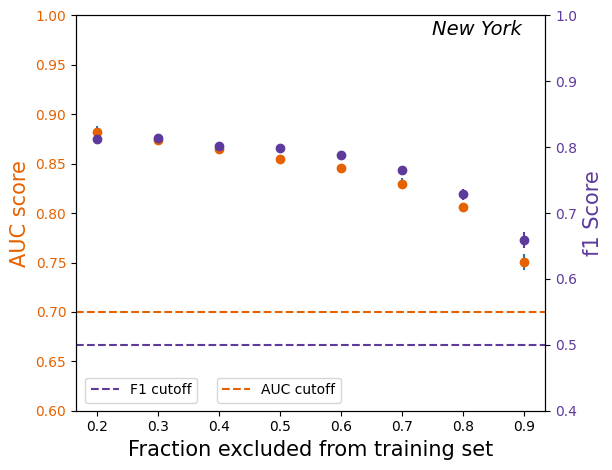

In [ ]:
##############################################################################################
#Plot variability in f1 and ROC-AUC with decreasing split sizes
##############################################################################################
fig, ax1 = plt.subplots()

color1 ='#E66100'
ax1.set_xlabel('Fraction excluded from training set', fontsize=15)
ax1.set_ylabel('AUC score', color=color1, fontsize=15)
ax1.errorbar(x=sizes, y=auc_scores_size, fmt='o', yerr=y_errors_roc, markerfacecolor=color1, markeredgecolor=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(0.6, 1)
ax1.axhline(y=0.7, color=color1, linestyle='--', label = 'AUC cutoff')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color2 =  '#5D3A9B'
ax2.set_ylabel('f1 Score', color=color2, fontsize=15)  # we already handled the x-label with ax1
ax2.errorbar(x=sizes, y=f1_scores_all, fmt='o', yerr=y_errors_f1, ecolor=color2, markerfacecolor=color2, markeredgecolor=color2);

ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()  # otherwise the right
ax2.set_ylim(0.4, 1)
ax2.axhline(y=0.5, color=color2, linestyle='--',  label = 'F1 cutoff')
ax1.text(x=0.75, y = 0.98, s='New York',
        style ='italic',
        fontsize = 14)
ax1.legend(loc=[0.3, 0.02])
ax2.legend(loc=[0.02, 0.02])


plt.show()

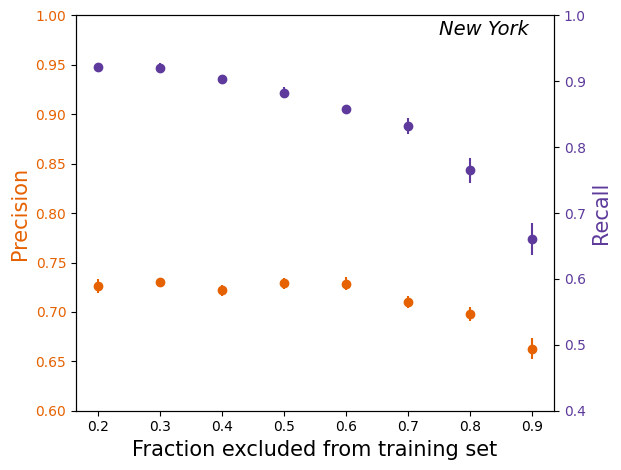

In [6]:
fig2, ax3 = plt.subplots()

color1 ='#E66100'
ax3.set_xlabel('Fraction excluded from training set', fontsize=15)
ax3.set_ylabel('Precision', color=color1, fontsize=15)
ax3.errorbar(x=sizes, y=precision_scores_all, fmt='o', yerr=precision_scores_errors, ecolor=color1,markerfacecolor=color1, markeredgecolor=color1)
ax3.tick_params(axis='y', labelcolor=color1)
ax3.set_ylim(0.6, 1)
ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis

color2 =  '#5D3A9B'
ax4.set_ylabel('Recall', color=color2, fontsize=15)  # we already handled the x-label with ax1
ax4.errorbar(x=sizes, y=recall_scores_all, fmt='o', yerr=recall_scores_errors, ecolor=color2, markerfacecolor=color2, markeredgecolor=color2);

ax4.tick_params(axis='y', labelcolor=color2)

fig2.tight_layout()  # otherwise the right
ax4.set_ylim(0.4, 1)
ax3.text(x=0.75, y = 0.98, s='New York',
        style ='italic',
        fontsize = 14)



plt.show()

In [ ]:

Pb_data = pd.read_csv('/content/drive/My Drive/data/NY dataset full.csv')
Pb_data = Pb_data.merge(ny_water_utilities, left_on='zip code', right_on= 'ZIP_CODE')
Pb_data['unsafe'] = Pb_data['Number of Outlets, Result > 15 ppb']>0
#preprocess data
Pb_data = Pb_data.drop_duplicates('School')
distance_matrix = create_distance_matrix(Pb_data)
features_over_size={}
features, labels = preprocess_data(Pb_data, 15, True)
poverty_and_income = ['b17020', 'b29003', 'b29004', 'b19101', 'b19083', 'b21004', 'b17005']
race = ['b02001']
sex_based_determinants = ['b01001', 'b21004']
household_social_determinants=['b16009','b17019', 'b17021']
utilities_data = state_water_aggregate.columns

categories=[poverty_and_income, race, sex_based_determinants,household_social_determinants, utilities_data]
dict_categories=[poverty_and_income, race, sex_based_determinants, household_social_determinants, utilities_data, ['Closest school Pb']]

importances_dataframe_ny=pd.DataFrame(index=np.arange(0,6), columns = sizes)
cat_feat=pd.DataFrame(columns = ['size', 'category','importance'])

for size in sizes:
  train_features, test_features, train_labels, test_labels= train_test_split(features, 
      labels, test_size = size, random_state = 42)

  train_features_with_name = train_features.merge(Pb_data[['School']], how='left',  left_index=True, right_index=True).dropna()
  test_features_with_name = test_features.merge(Pb_data[['School']], how='left', left_index=True, right_index=True).dropna()

  test_features['Closest School Pb'] = find_closest_school(Pb_data, test_features_with_name, train_features_with_name, distance_matrix)
  train_features['Closest School Pb'] = find_closest_school(Pb_data, train_features_with_name, train_features_with_name, distance_matrix)

  rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, criterion='entropy', max_depth= 20, oob_score=True, class_weight={0:1,1:100})

  # Fit model
  rf.fit(train_features.fillna(0), train_labels)

#Define decision threshold for random forest
  threshold = 0.5

  # Predict using selected threshold
  predicted_proba = rf.predict_proba(test_features.fillna(0))
  rf_prediction = (predicted_proba [:,1] >= threshold).astype('int')
  fpr, tpr, thresholds = roc_curve(test_labels, predicted_proba[:,1])
  # get area under the curve
  roc_auc = auc(fpr, tpr)

  ##IMPORTANCES

  importances = rf.feature_importances_
  feature_lst = list(train_features.columns)
  for feature_index in np.arange(0, len(feature_lst)):
    for i in np.arange(0, len(categories)):
      if str.lower(feature_lst[feature_index][:6]) in categories[i] or feature_lst[feature_index] in categories[i]:
        new_val = importances_dataframe_ny.iloc[i, sizes.index(size)]+importances[feature_index]
        importances_dataframe_ny.iloc[i, sizes.index(size)] = new_val
        cat_feat = cat_feat.append(pd.Series({'size':size, 'category':i, 'importance':importances[feature_index]}), ignore_index=True)

      elif feature_lst[feature_index] == 'Closest School Pb':
        importances_dataframe_ny.iloc[5, sizes.index(size)] = importances[feature_index]
        cat_feat = cat_feat.append(pd.Series({'size':size, 'category':5, 'importance':importances[feature_index]}), ignore_index=True)

        break
        

 


<ipython-input-8-3613ffc96411>:4: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  Pb_data = pd.read_csv('/content/drive/My Drive/data/NY dataset full.csv')


NameError: ignored

In [ ]:
cat_feat=cat_feat.groupby(['size', 'category']).agg(lambda x: np.mean(x.sort_values(ascending=False)[:5]))
cat_feat.to_csv("/content/drive/My Drive/data/ny_feature_average2.csv", index=False)


Feature ranking:


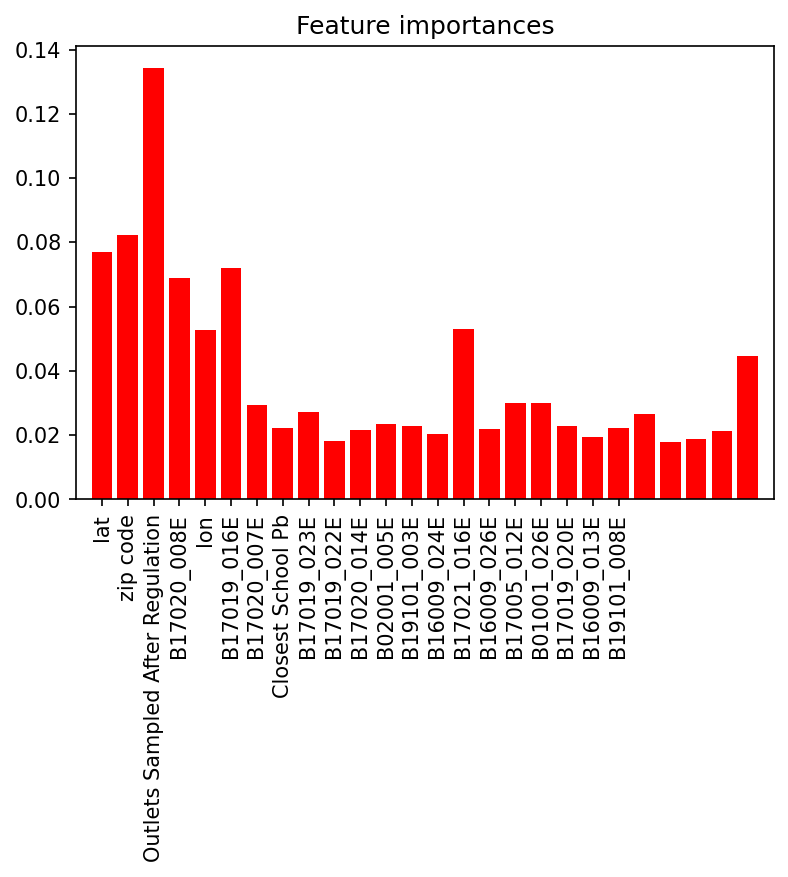

In [ ]:
##############################################################################################
#Feature importance analysis
#
##############################################################################################
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_head = train_features.columns
feature_head= feature_head[indices]
# Print the feature ranking
print("Feature ranking:")
# Plot the impurity-based feature importances of the forest
plt.figure(dpi=150)
plt.title("Feature importances")
plt.bar(range(train_features.shape[1]), importances,
        color="r")
plt.xticks(range(0,21), feature_head, rotation='vertical')
plt.xlim([-1, train_features.shape[1]])
plt.show()
